# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


***Identification of stages at which sampling occurs in the model:***
> *Sampling occurs at 4 distinct stages:*

*1) Set up stage*
<br>*<u>Sampling procedure</u>: Initialization and staging.*<br>
<br>*<u>Functions used</u>: events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({event': events, 'infected': False, 'traced': np.nan}) ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())*<br>
<br>*<u>Sample size</u>: 1000 individuals (Weddings: 200 individuals (20% of the frame). Brunches: 800 individuals (80% of the frame)).*<br>
<br>*<u>Sampling frame</u>: All 1,000 individuals in the ppl DataFrame (200 wedding guests, 800 brunch guests).*<br>
<br>*<u>Underlying distribution</u>: Staging relies on Bernoulli distribution logic*<br>

*2) Initial infection*
<br>*<u>Sampling procedure</u>: Simple random sampling without replacement.*<br>
<br>*<u>Functions used</u>: infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)*<br>
<br>*<u>Sample size</u>: 100 individuals ($1,000 \times 0.10$).*<br>
<br>*<u>Sampling frame</u>: All 1,000 individuals in the ppl DataFrame (200 wedding guests, 800 brunch guests).*<br>
<br>*<u>Underlying distribution</u>: Similar to hypergeometric process, though implemented via np.random.choice*<br>

*3) Primary contact tracing*
<br>*<u>Sampling procedure</u>: Independent Bernoulli trials*<br>
<br>*<u>Functions used</u>: ppl.loc[ppl['infected'], 'traced'] = (np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS)*<br>
<br>*<u>Sample size</u>: expected 20 individuals ($100 \times 0.20$), though this varies per run.*<br>
<br>*<u>Sampling frame</u>: subset of only infected individuals*<br>
<br>*<u>Underlying distribution</u>: Bernoulli Distribution with probability TRACE_SUCCESS = 0.20. Each infected person has a 20% chance of being traced independently of others.*<br>

*4) Secondary contact tracing*
<br>*<u>Sampling procedure</u>: Cluster-based sampling - if there are a certain number of primary traces (THRESHOLD) for a given event, all individuals who were infected at that event are "sampled."*<br>
<br>*<u>Functions used</u>: event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts() events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index*<br>
<br>*<u>Sample size</u>: Variable. It depends on whether the wedding or brunch hit the SECONDARY_TRACE_THRESHOLD.*<br>
<br>*<u>Sampling frame</u>: Infected individuals who were not caught in the primary trace but attended a "high-trace" event.*<br>
<br>*<u>Underlying distribution</u>: Deterministic thresholding, but triggered by random outcomes from the earlier sampling steps.*<br>

Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

***Observations on outputted graphs***
<br>*When we modify the repetitions and run the script multiple times:*<br>

> *1. <u>At 10 repetitions</u>: Histograms are noisy. Since sample size is so small, the "Traces" distribution look completely different every time we "run" it. They vary wildly between runs.*

> *2. <u>At 100 repetitions</u>: The distributions begin to stabilize, showing a clear shift where weddings (red) appear to be responsible for more cases than they actually are (blue). However, the exact height and spread of the bins still fluctuate.*

> *3. <u>At 1000 repititions</u>: The distribution stabilizes and the bias becomes visually clear and consistent.*

***Reproducibility of the results:*** 
<br> *The results are currently not reproducible across the runs. The reason being small Monte Carlo sample sizes (10, 100) and uncontrolled randomness in infection and tracing processes. Thus, it makes it impossible for another researcher to get the exact same figures from our code.*<br>

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The script needs to produce the same output when run multiple times.

***Altering code to make it reproducible***
<br>*Change made: Set a random seed before any random sampling occurs, i.e., adding it near the top of the script just after importing necessary libraries. For example, **np.random.seed(42)** - Random seed ensures the random number sequence is identical every run*<br>

***Effect on reproducibility of script***
<br>*By setting np.random.seed(42), we initialize NumPy’s pseudorandom number generator to a fixed state and thus, produce the same sequence of random numbers each time the script is run. As a result, running the script multiple times produces identical histograms and identical proportions for infections and traced cases. This allows researchers to verify our work and ensure that any changes in the output are due to code modifications rather than random chance.*<br>

## Code

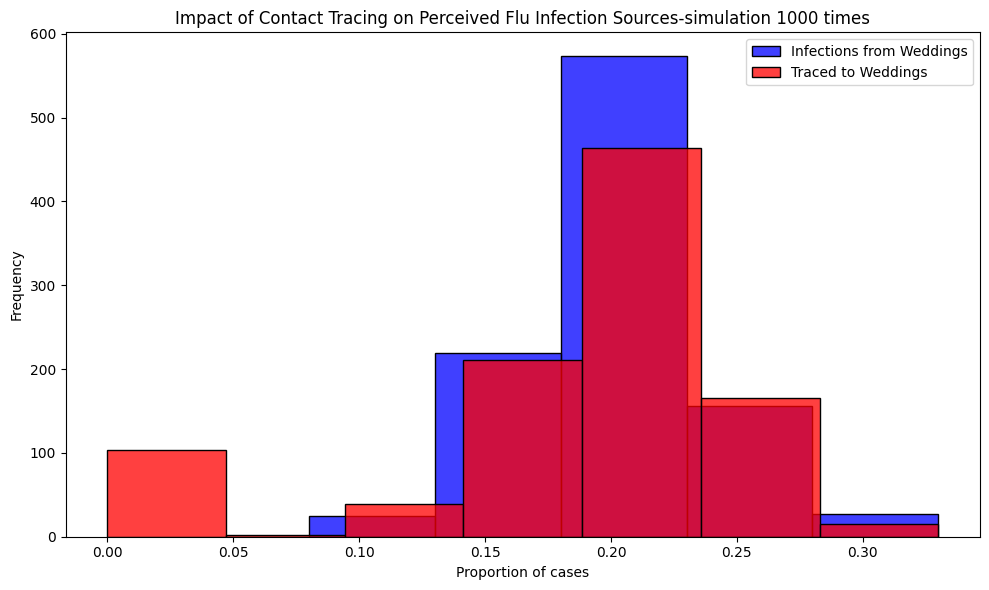

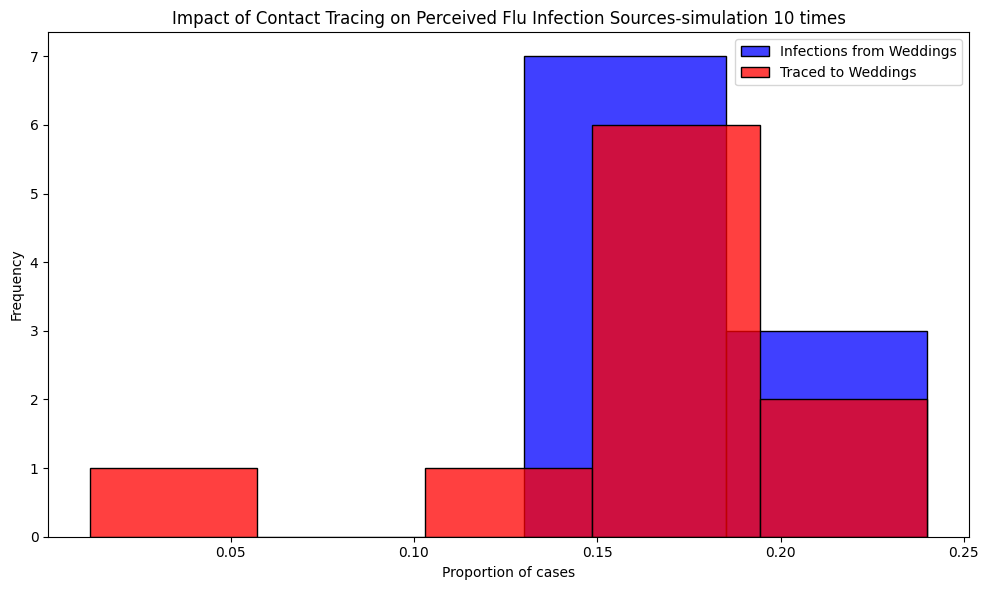

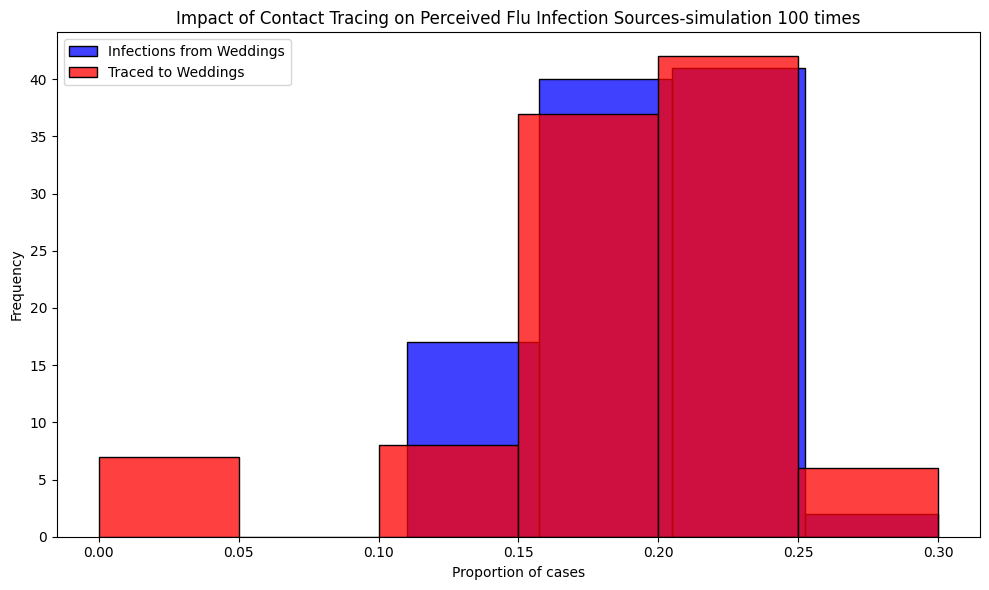

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources-simulation 1000 times")
plt.legend()
plt.tight_layout()
plt.show()

# Run the simulation 10 times
results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources-simulation 10 times")
plt.legend()
plt.tight_layout()
plt.show()

# Run the simulation 100 times
results = [simulate_event(m) for m in range(100)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources-simulation 100 times")
plt.legend()
plt.tight_layout()
plt.show()

# Altered code for reproducibility

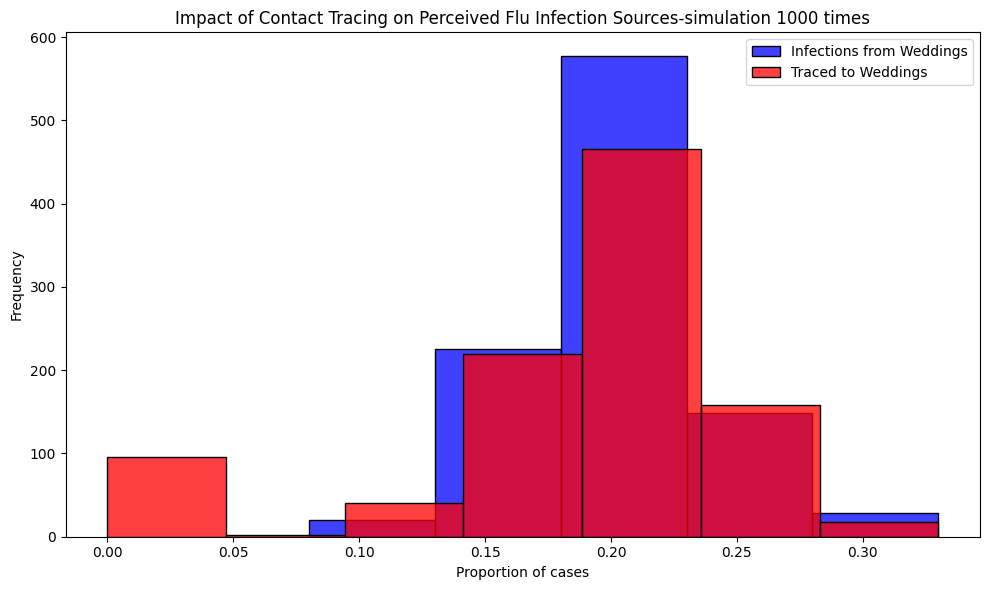

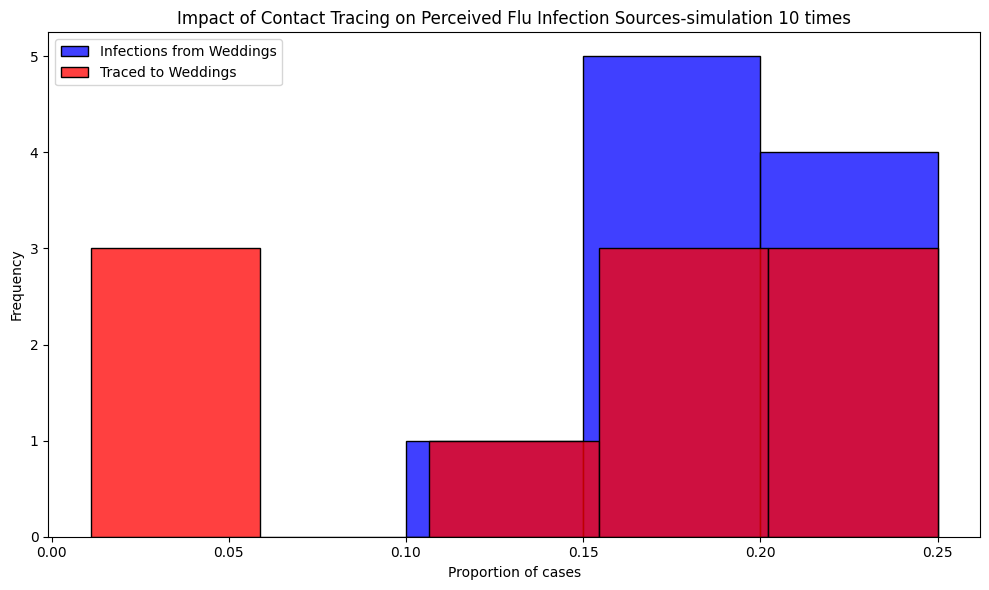

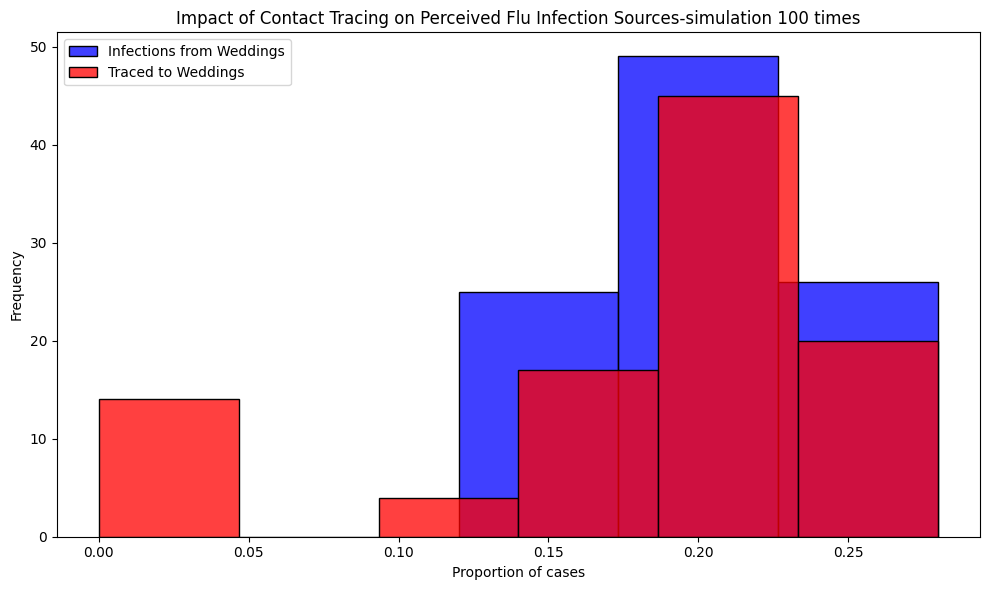

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# code to ensure that results are reproducible
np.random.seed(42) # Random seed ensures the random number sequence is identical every run

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources-simulation 1000 times")
plt.legend()
plt.tight_layout()
plt.show()

# Running the simulation 10 times
results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources-simulation 10 times")
plt.legend()
plt.tight_layout()
plt.show()

# Running the simulation 100 times
results = [simulate_event(m) for m in range(100)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources-simulation 100 times")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 02 February 2026`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
